In [94]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance

In [95]:
#Motion blur
def blurImage(img, k = 1200):
    size_factor = 0.1 # Constant determining kernel size
    kernel_size = int(size_factor * k)
    # Create the vertical kernel.
    kernel_v = np.zeros((kernel_size, kernel_size))

    # Create a copy of the same for creating the horizontal kernel.
    kernel_h = np.copy(kernel_v)

    # Fill the middle row with ones.
    kernel_v[:, int((kernel_size - 1)/2)] = np.ones(kernel_size)
    kernel_h[int((kernel_size - 1)/2), :] = np.ones(kernel_size)

    # Normalize kernels
    kernel_v /= kernel_size
    kernel_h /= kernel_size

    # Apply the vertical kernel.
    vertical_mb = cv2.filter2D(img, -1, kernel_v)

    # Apply the horizontal kernel.
    horizonal_mb = cv2.filter2D(img, -1, kernel_h)

    return vertical_mb, horizonal_mb

# Gets the highest speed limit sign in an annotation, -1 if not present
def getMaxSpeed(annotation_value):
    prefix = 'pl'
    speeds = [int(obj['category'][len(prefix):]) for obj in annotation_value['objects']
              if obj['category'].startswith(prefix)]
    return np.amax(speeds, initial=-1) # Return maximum speed found

# Gets mean and variance of all annotations
# The annotations passed should be the values of the json dictionary
def getSpeedDistribution(annotations):
    speeds = [getMaxSpeed(value) for (_, value) in annotations.items()] # Get all entries
    speeds = [speed for speed in speeds if speed > 0] # Filter out all negative/zero entries

    return np.mean(speeds), np.std(speeds)

# Gets the speed to use for an image
def getSpeed(annotation_value, mean, std):
    speed = getMaxSpeed(annotation_value)
    if speed <= 0: # No speed limit sign
        speed =  np.random.normal(mean, std)
    return speed # Return answer

In [96]:
#Rain
def generate_random_lines(imshape,slant,drop_length):
    drops=[]
    for i in range(1000):
        ## If You want heavy rain, try increasing this
        if slant<0:
            x= np.random.randint(slant,imshape[1])
        else:
            x= np.random.randint(0,imshape[1]-slant)
            y= np.random.randint(0,imshape[0]-drop_length)
            drops.append((x,y))

    return drops

def add_rain(image):
    imshape = image.shape
    slant_extreme=10
    slant= np.random.randint(-slant_extreme,slant_extreme)
    drop_length=20
    drop_width=2
    drop_color=(200,200,200)
    ## a shade of gray
    rain_drops= generate_random_lines(imshape,slant,drop_length)
    out = np.copy(image)
    for rain_drop in rain_drops:
        cv2.line(out,(rain_drop[0],rain_drop[1]),(rain_drop[0]+slant,rain_drop[1]+drop_length),drop_color,drop_width)

    image_blur= cv2.blur(out,(3,3))
    ## rainy view are blurry

    brightness_coefficient = 0.7
    ## rainy days are usually shady

    image_HLS = cv2.cvtColor(image_blur,cv2.COLOR_RGB2HLS)
    ## Conversion to HLS

    image_HLS[:,:,1] = image_HLS[:,:,1]*brightness_coefficient
    ## scale pixel values down for channel 1(Lightness)

    image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB)
    ## Conversion to RGB

    return image_RGB

In [97]:
#Random noise
def make_noisy(image):
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.1
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
    out[coords] = 0
    return out


c:\users\a_sta\onedrive - worcester polytechnic institute (wpi.edu)\2021-22\cs 539\final project\venv\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # This is added back by InteractiveShellApp.init_path()
c:\users\a_sta\onedrive - worcester polytechnic institute (wpi.edu)\2021-22\cs 539\final project\venv\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


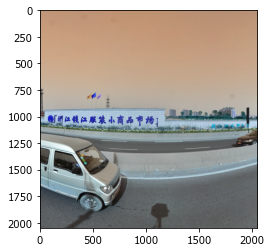

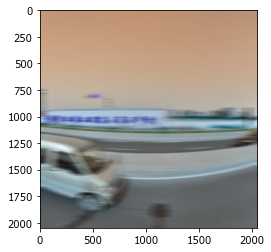

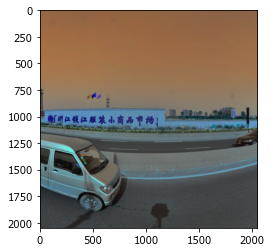

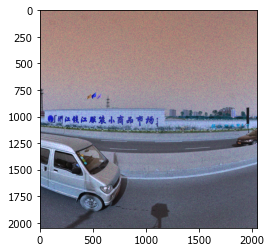

In [98]:
#read the file
img = cv2.imread('./data/other/8.jpg')
fig, ax = plt.subplots()
ax.imshow(img)

vertical_mb, horizontal_mb = blurImage(img)
fig, ax = plt.subplots()
ax.imshow(horizontal_mb)

rain = add_rain(img)
fig, ax = plt.subplots()
ax.imshow(rain)

noise = make_noisy(img)
fig, ax = plt.subplots()
ax.imshow(noise )
